### Курсовой проект 
Дьяченко Даниил @daniilstv

Построение модели, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по кредиту.
https://geekbrains.ru/lessons/58711


Полезные ссылки:

Про категорирование переменных:
https://dyakonov.org/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/

https://habr.com/ru/post/456294/


#### 1. Подгружаем модули, вспомогательные функции

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

# from scipy.stats import shapiro
# from scipy.stats import probplot
# from scipy.stats import ttest_ind, mannwhitneyu
# from scipy.stats import chi2_contingency
# from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

# import xgboost as xgb
# import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:

def df_info(input_dataframe):
    ''' Определение формы датафрейма. '''
    print("Форма: {}\n\nСтолбцы: {}\n\nИндексы: {}\n".format(input_dataframe.shape, 
                                          input_dataframe.columns, input_dataframe.index))
    print('Тип данных:\n',input_dataframe.dtypes)
    #print(input_dataframe.head())
    #print(input_dataframe.describe())
    
    return 


def clean_data_3std(df, columns):
    '''Стандартизация данных в 3 сигма'''
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
        conf_interval = mean + std3
        
        df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ] = mean
        

def make_dummy(df, column, dict_for_map):
    '''Dummy из словаря dict_for_map = {"Short Term": 0, "Long Term": 1} '''
    for i in column:
#         print(i)
        maper = dict_for_map
        df[i] = df[i].map(maper)
    return 

def dict_from_value_counts(df, column):
    '''Словарь из агрегированных значений для преобразования в dummy'''  
    names = []
    for i in df[column].value_counts().index:
        names.append(i)
    dict_for_map = dict.fromkeys(names)
    return dict_for_map

def balance_df_by_target(df, target_name):
# докинуть  
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def print_scatter(df, col):
    '''Графики зависимости параметра и целевой переменной df[col]'''
    for i in col:
        print("Разброс параметра", i)
        plt.scatter(df[i],df["Credit Default"])
        plt.show()

def find_discrete_col(df, col, n):
    '''Проверка распределения и выявление дискретных значений  df[col]  '''
    discrete_col = []
    for i in col:
        #print('i',i)
        a = df[i].value_counts() 
        #print(f'Колонка: {i}  Длина (проверяется): {len(a)} \n')
        if len(a) <= n:
            discrete_col.append(i)
    #print(discrete_col)
    return discrete_col
        
def analyse_data_3std(df, columns):
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
#         conf_interval = mean + std3
        print("Среднее по ", i , "=", mean)
        print("+3 сигма =",mean + std3)
#         df_deviation = df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ]
        df_deviation = df.loc[ ((df[i] < (mean - std3)) | ( df[i] > (mean + std3) )), i ]
        print("Кол-во выбросов = ",len(df_deviation))
        print("Выбросы:", df_deviation,"\n")
        
        #df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ] = mean

def del_3std_deviation(df, columns):
    '''Сделать бэкап df перед использованием!'''
    print("Форма на входе = ", df.shape)
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
#         conf_interval = mean + std3
        df= df[(df[i] < (mean - std3)) | ( df[i] < (mean + std3) )]     
    print("Форма на выходе = ", df.shape)    
    return df

def cat_num_features(df , TARGET_NAME='Credit Default'):
    '''Отбирает категории, отделяет числовые переменны'''
    #TARGET_NAME = 'Credit Default'
    BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
    print("Переменные:", BASE_FEATURE_NAMES)


    CAT_FEATURE_NAMES = find_discrete_col(df_train, BASE_FEATURE_NAMES, 15)
    NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))

    print("CAT_FEATURE_NAMES",CAT_FEATURE_NAMES)
    print("NUM_FEATURE_NAMES",NUM_FEATURE_NAMES)
    return CAT_FEATURE_NAMES, NUM_FEATURE_NAMES

In [4]:

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [49]:
# https://github.com/mitabunov/DS_febr2020_Geek/blob/master/MTabunov_solution.ipynb
import missingno as msno

def view_matrix(df_train):
    
    '''показывает пропуски по колонкам и общую информацию о сете'''
    for colname in df_train.select_dtypes(include='object').columns:
        print(str(colname) + '\n\n' + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
    msno.matrix(df_train) 
    display("/usr/local/share/datasets/matrix_sorted.png")
    
    print(df_train.head())
    print(len(df_train) - df_train.count(), df_train.info())
    
    

def prepare_label(df_train):
    '''функция преобразующая строковые объекты в метки'''
    
    le = LabelEncoder()

    for col in df_train.columns:       
        if df_train[col].dtypes=='object':
            df_train[col]=le.fit_transform(df_train[col].astype(str))
    return df_train

def missing_imputer(df_train):
    '''функция заполняющая пробелы'''
    
    numeric_cols = df_train.select_dtypes(include=[np.number])

    imp_iter = IterativeImputer(n_nearest_features=4,max_iter=10, sample_posterior=True, random_state=123)
    df_train = imp_iter.fit_transform(numeric_cols)
 
    df_train = pd.DataFrame(df_train, columns=numeric_cols.columns)
    
    return df_train


#### 2. Подгружаем данные, проводим поверхностный анализ фрейма

In [5]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'


df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_info(df_train)

Форма: (7500, 17)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

Индексы: RangeIndex(start=0, stop=7500, step=1)

Тип данных:
 Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount 

Категорийные признаки: Home Ownership, Years in current job, Tax Liens, Number of Credit Problems, Bankruptcies, Purpose, Term

In [7]:
# Привести к категориям  Home Ownership, Years in current job, Tax Liens, 
# Number of Credit Problems, Bankruptcies, Purpose, Term

In [8]:
df_info(df_test)
df_test.head()

Форма: (2500, 16)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')

Индексы: RangeIndex(start=0, stop=2500, step=1)

Тип данных:
 Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float6

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64


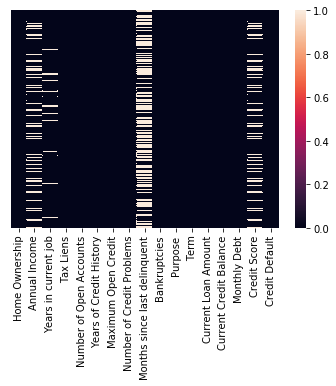

In [9]:
# Проверить на NaN
print(len(df_train) - df_train.count())
sns.heatmap(df_train.isnull(),yticklabels=False)

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64


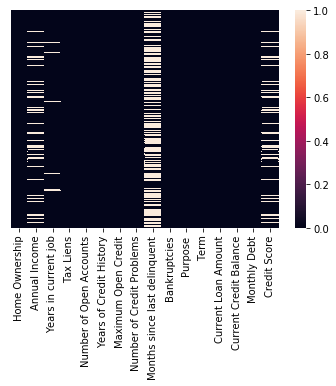

In [10]:
# Проверить на NaN
print(len(df_test) - df_test.count())
sns.heatmap(df_test.isnull(),yticklabels=False)




#### 3. Вводим метки, фиктивные переменные, цифруем признаки

In [11]:
# Обзор object - признаков
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************

Te

In [12]:
dict_from_value_counts(df_train, 'Home Ownership')

{'Home Mortgage': None, 'Rent': None, 'Own Home': None, 'Have Mortgage': None}

In [13]:
dict_for_map = {'Home Mortgage': 1, 'Rent': 2, 'Own Home': 0, 'Have Mortgage': 3}

make_dummy(df_train, ['Home Ownership'], dict_for_map)
make_dummy(df_test, ['Home Ownership'], dict_for_map)

In [14]:
dict_from_value_counts(df_train, 'Purpose')

{'debt consolidation': None,
 'other': None,
 'home improvements': None,
 'business loan': None,
 'buy a car': None,
 'medical bills': None,
 'major purchase': None,
 'take a trip': None,
 'buy house': None,
 'small business': None,
 'wedding': None,
 'moving': None,
 'educational expenses': None,
 'vacation': None,
 'renewable energy': None}

In [15]:
dict_for_map = {'debt consolidation': 1,
 'other': 0,
 'home improvements': 2,
 'business loan': 3,
 'buy a car': 4,
 'medical bills': 5,
 'major purchase': 6,
 'take a trip': 7,
 'buy house': 8,
 'small business': 9,
 'wedding': 10,
 'moving': 11,
 'educational expenses': 12,
 'vacation': 13,
 'renewable energy': 14}

make_dummy(df_train, ['Purpose'], dict_for_map)
make_dummy(df_test, ['Purpose'], dict_for_map)

In [16]:
dict_from_value_counts(df_train, 'Term')

{'Short Term': None, 'Long Term': None}

In [17]:
dict_for_map = {'Short Term': 0, 'Long Term': 1}

make_dummy(df_train, ['Term'], dict_for_map)
make_dummy(df_test, ['Term'], dict_for_map)

In [18]:
dict_from_value_counts(df_train, "Years in current job")

{'10+ years': None,
 '2 years': None,
 '3 years': None,
 '< 1 year': None,
 '5 years': None,
 '1 year': None,
 '4 years': None,
 '6 years': None,
 '7 years': None,
 '8 years': None,
 '9 years': None}

In [19]:
dict_for_map = {'10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '< 1 year': 0,
 '5 years': 5,
 '1 year': 1,
 '4 years': 4,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9}

make_dummy(df_train, ["Years in current job"], dict_for_map)
make_dummy(df_test, ["Years in current job"], dict_for_map)

In [20]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
print("Переменные:", BASE_FEATURE_NAMES)

CAT_FEATURE_NAMES = find_discrete_col(df_train, BASE_FEATURE_NAMES, 15)
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))

print("CAT_FEATURE_NAMES",CAT_FEATURE_NAMES)
print("NUM_FEATURE_NAMES",NUM_FEATURE_NAMES)

Переменные: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
NUM_FEATURE_NAMES ['Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Annual Income', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Months since last delinquent', 'Current Loan Amount']


In [21]:
# Проверка 
#CAT_FEATURE_NAMES = [ 'Years in current job', 'Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies']
for i in BASE_FEATURE_NAMES:
    print(i)
    print(    df_train[i].value_counts(), "\n") 
    #print(    df_test[i].value_counts(), "\n") 
    
    

Home Ownership
1    3637
2    3204
0     647
3      12
Name: Home Ownership, dtype: int64 

Annual Income
1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64 

Years in current job
10.0    2332
2.0      705
3.0      620
0.0      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64 

Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64 

Number of Open Accounts
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     1

#### Анализируем выбросы

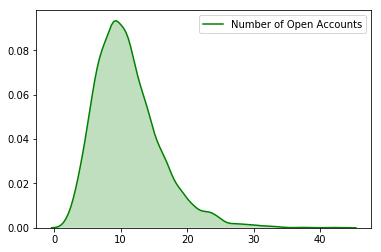

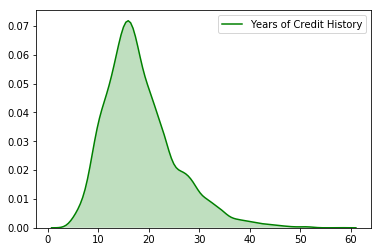

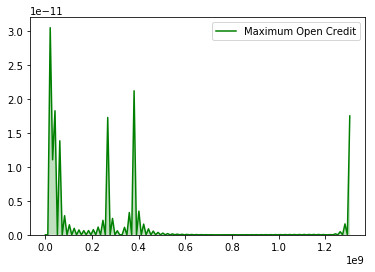

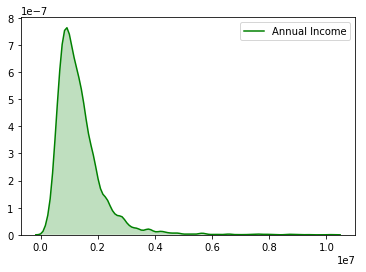

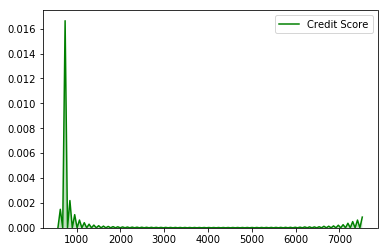

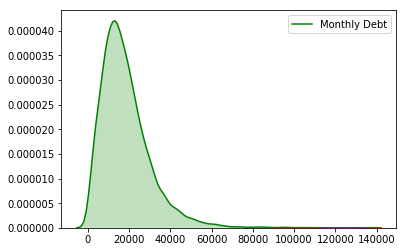

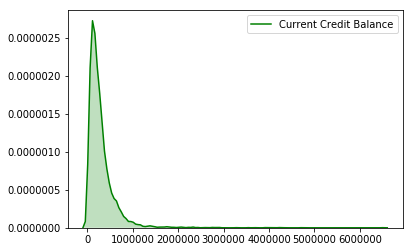

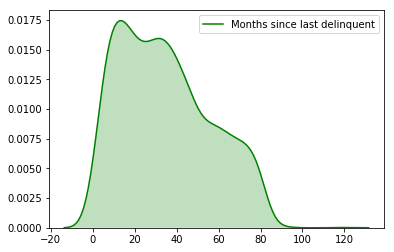

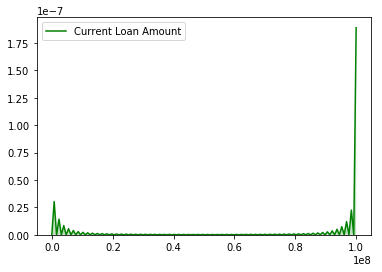

In [22]:
col = NUM_FEATURE_NAMES

for i in col:
   # print(i)
    sns.kdeplot(df_train[i], shade=True, label=i, color='g')
    plt.show()

In [23]:
analyse_data_3std(df_train, NUM_FEATURE_NAMES)
df_train.describe()

Среднее по  Number of Open Accounts = 11.0
+3 сигма = 26.0
Кол-во выбросов =  76
Выбросы: 305     32.0
342     33.0
423     32.0
464     31.0
658     30.0
        ... 
6926    30.0
7089    27.0
7156    28.0
7292    28.0
7478    30.0
Name: Number of Open Accounts, Length: 76, dtype: float64 

Среднее по  Years of Credit History = 18.0
+3 сигма = 39.0
Кол-во выбросов =  96
Выбросы: 100     39.6
179     39.3
206     40.3
247     52.2
273     43.9
        ... 
6883    40.5
7022    42.0
7187    40.5
7251    51.0
7366    48.3
Name: Years of Credit History, Length: 96, dtype: float64 

Среднее по  Maximum Open Credit = 945154.0
+3 сигма = 49023805.0
Кол-во выбросов =  4
Выбросы: 44      3.800523e+08
617     1.304726e+09
2023    5.756256e+07
2617    2.655129e+08
Name: Maximum Open Credit, dtype: float64 

Среднее по  Annual Income = 1366392.0
+3 сигма = 3902409.0
Кол-во выбросов =  98
Выбросы: 166     4580976.0
369     4192065.0
384     4333577.0
422     4667616.0
585     4772800.0
          .

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7129.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.344133,1.366392e+06,5.880348,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.256267,0.259200,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,0.633634,8.453392e+05,3.620092,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,1.355448,0.438225,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1.000000,8.443410e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,1.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,2.000000,1.640137e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,1.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


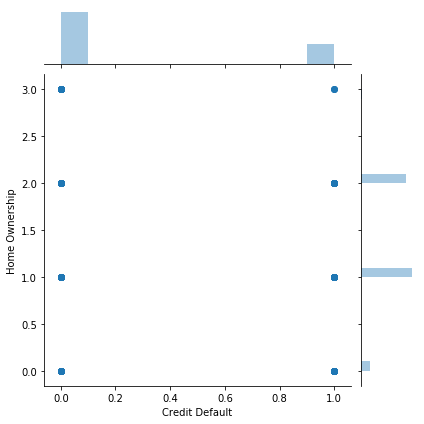

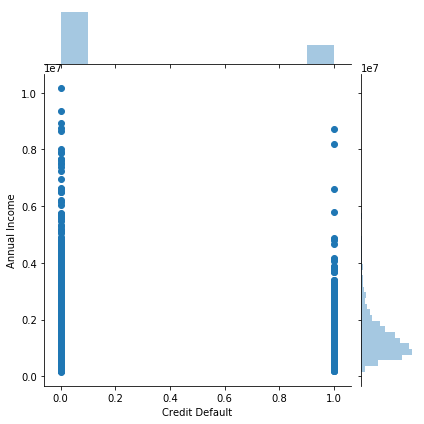

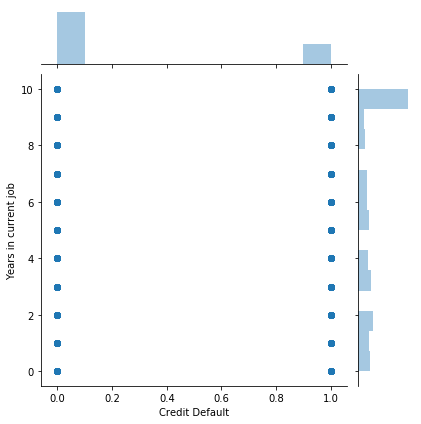

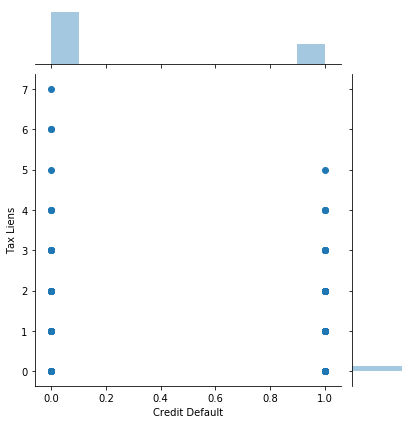

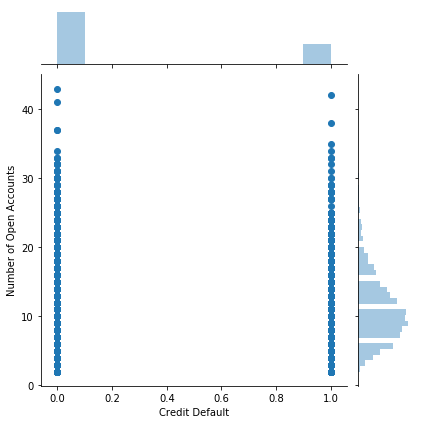

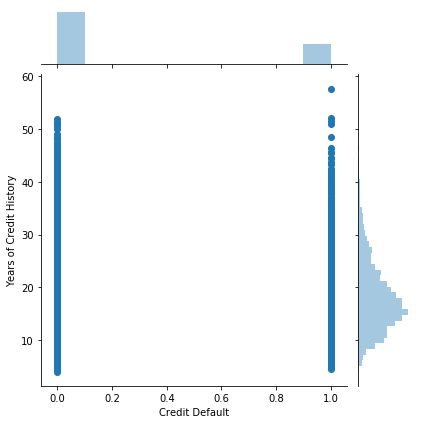

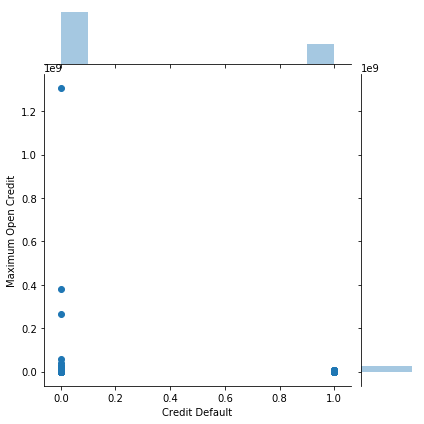

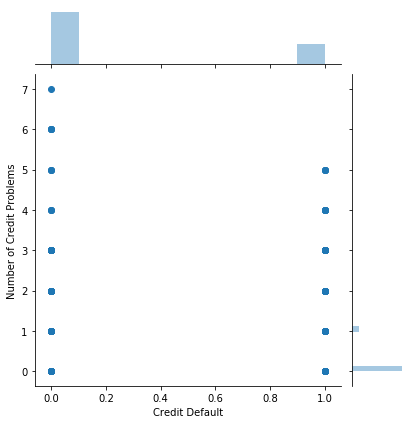

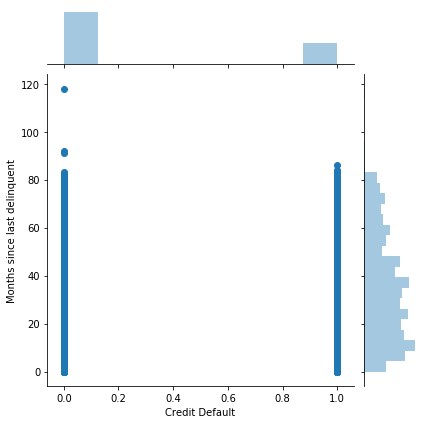

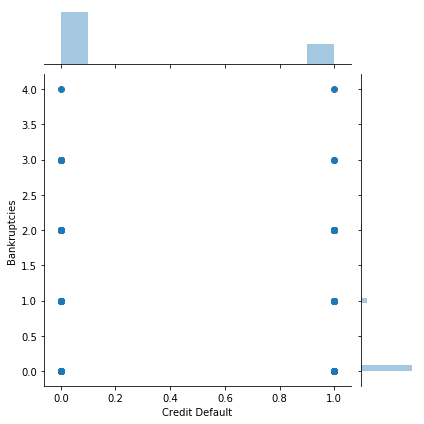

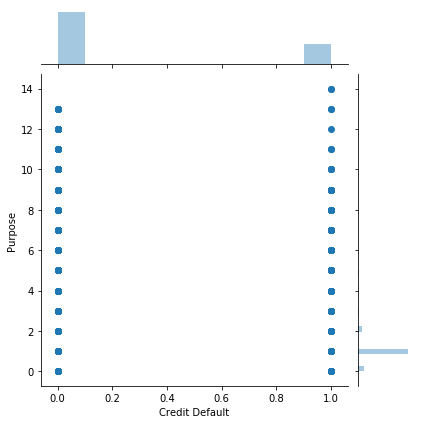

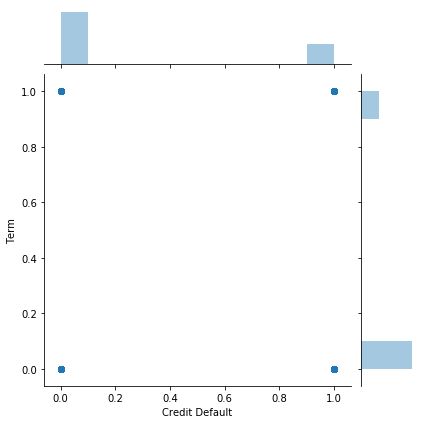

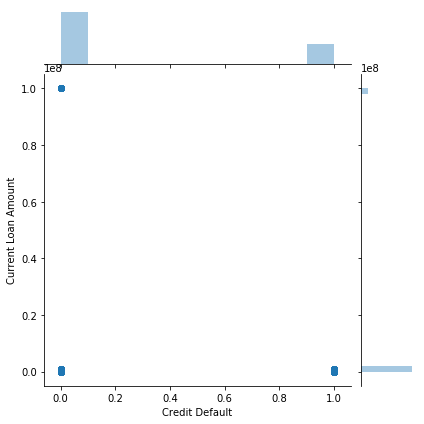

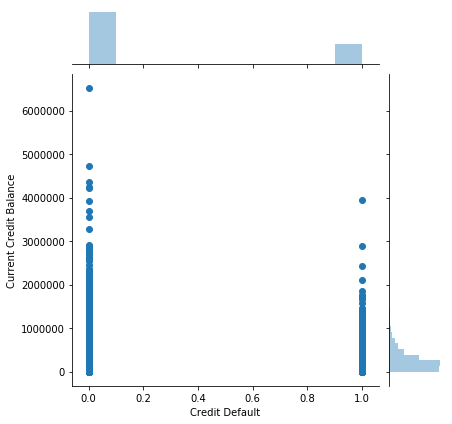

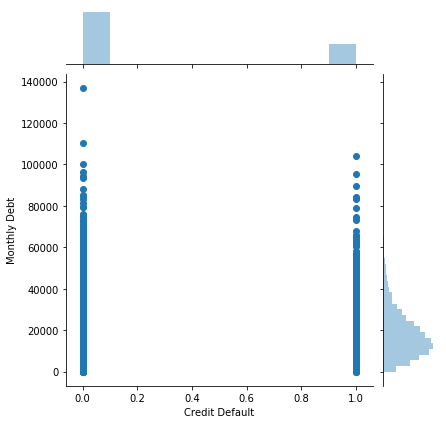

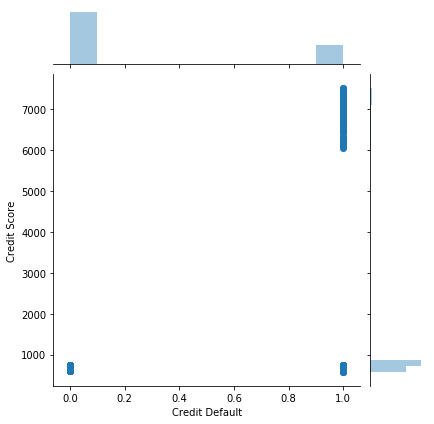

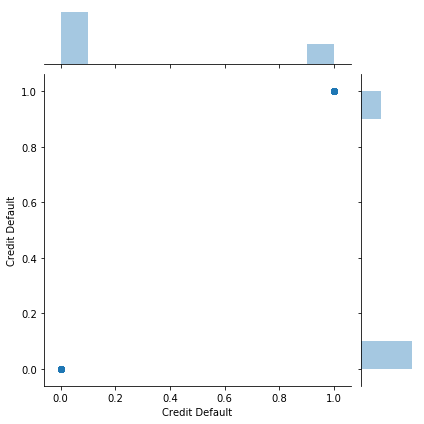

In [32]:
# for column in df_train:
#     sns.jointplot(y=column, x=TARGET_NAME, data=df_train)
#     plt.show()

In [24]:
# Выбрали, что почистить выше 3-сигма и удалили - опция
#col = ['Months since last delinquent', 'Maximum Open Credit']

col = NUM_FEATURE_NAMES


df = df_train.copy()

for i in col:
    mean = np.round(df[i].mean())
    std3 = 3 * np.round(df[i].std())
    conf_interval = mean + std3
    print(mean, std3, conf_interval)
    df_train = df[(df[i] < (mean - std3)) | ( df[i] < (mean + std3) )] 
df_train.describe()

# Сравнить влияние на модель!

11.0 15.0 26.0
18.0 21.0 39.0
945154.0 48078651.0 49023805.0
1366392.0 2536017.0 3902409.0
1151.0 4812.0 5963.0
18314.0 35781.0 54095.0
289833.0 953613.0 1243446.0
35.0 66.0 101.0
11873177.0 95778369.0 107651546.0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7129.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.344133,1.366392e+06,5.880348,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.256267,0.259200,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,0.633634,8.453392e+05,3.620092,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,1.355448,0.438225,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1.000000,8.443410e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,1.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,2.000000,1.640137e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,1.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [44]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
NUM_FEATURE_NAMES = ['Monthly Debt_lg', 'Number of Open Accounts_lg', 'Current Credit Balance', 'Current Loan Amount', 'Credit Score', 'Years of Credit History_lg', 'Months since last delinquent', 'Annual Income_lg', 'Maximum Open Credit']

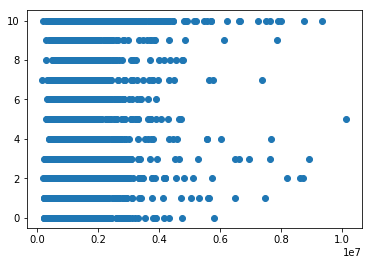

In [25]:
df = df_train[['Annual Income','Years in current job']]

plt.scatter(df_train['Annual Income'], df_train['Years in current job'])
plt.show()

# проверять на выбросы через 3 сигмы или z-score или персентиль 95%

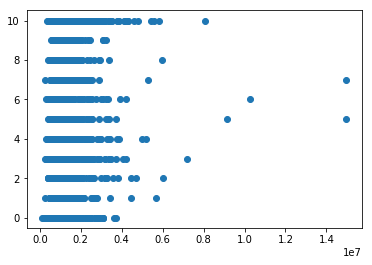

In [26]:
plt.scatter(df_test['Annual Income'], df_test['Years in current job'])
plt.show()

In [27]:
print(df_train.loc[df_train['Annual Income'] > 10000000,['Annual Income', 'Years in current job']])
print(df_test.loc[df_test['Annual Income'] > 8000000,['Annual Income', 'Years in current job']])

      Annual Income  Years in current job
6472     10149344.0                   5.0
      Annual Income  Years in current job
36       14934114.0                   7.0
194      14975610.0                   5.0
860       8057178.0                  10.0
1089     10275770.0                   6.0
1235      9163985.0                   5.0


In [28]:
# Опция - просто удалить выбросы

#df_train = df_train.drop([6472])
#df_test = df_test.drop([36,194,1089])

In [29]:
value = np.round(df_train.loc[ ((df_train['Years in current job'] == 5) & (df_train['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_train.loc[6472,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 7) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[36,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 5) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[194,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 6) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[1089,['Annual Income']] = value



In [30]:
print(df_train.loc[df_train['Annual Income'] > 10000000,['Annual Income', 'Years in current job']])
print(df_test.loc[df_test['Annual Income'] > 8000000,['Annual Income', 'Years in current job']])

Empty DataFrame
Columns: [Annual Income, Years in current job]
Index: []
      Annual Income  Years in current job
860       8057178.0                  10.0
1235      9163985.0                   5.0


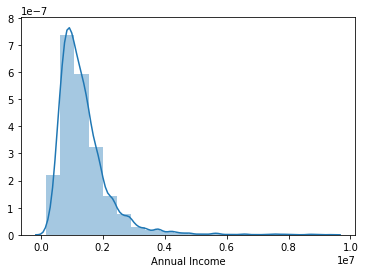

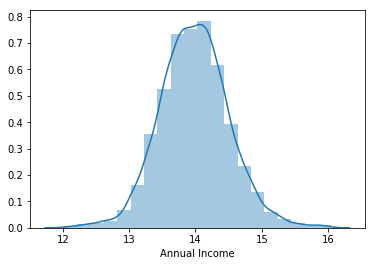

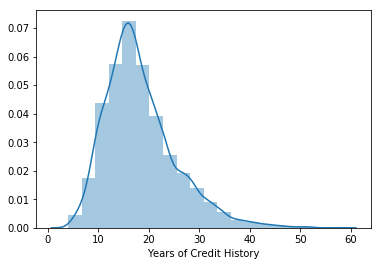

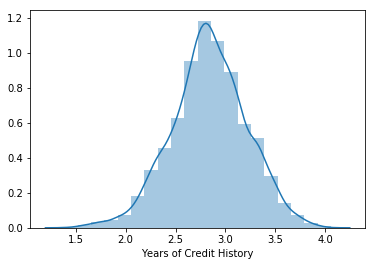

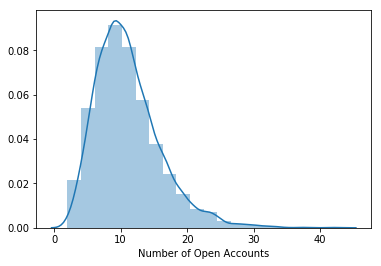

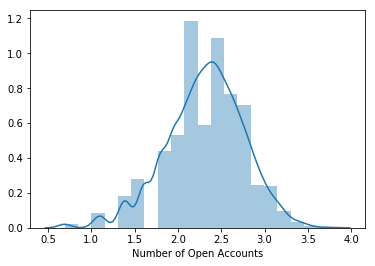

In [31]:
# Пробуем логарифмировать переменную
col = 'Annual Income', 'Years of Credit History',  'Number of Open Accounts' #, 'Monthly Debt',
for i in col:

    sns.distplot(df_train[i].dropna(), bins = 20)
    plt.show()
    sns.distplot(np.log(df_train[i].dropna()), bins = 20)
    plt.show()



In [32]:
# Выполнить логорифмирование - опция

col = 'Annual Income', 'Years of Credit History'   # 'Number of Open Accounts', 'Monthly Debt',

for i in col:
    txt = i+'_lg'
    df_train.loc[:, txt] = np.log(df_train[i])
    df_test.loc[:, txt] = np.log(df_test[i])
cat_num_features(df_train)


Переменные: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']
CAT_FEATURE_NAMES ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
NUM_FEATURE_NAMES ['Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Annual Income', 'Credit Score', 'Years of Credit History_lg', 'Monthly Debt', 'Current Credit Balance', 'Annual Income_lg', 'Months since last delinquent', 'Current Loan Amount']


(['Home Ownership',
  'Years in current job',
  'Tax Liens',
  'Number of Credit Problems',
  'Bankruptcies',
  'Purpose',
  'Term'],
 ['Number of Open Accounts',
  'Years of Credit History',
  'Maximum Open Credit',
  'Annual Income',
  'Credit Score',
  'Years of Credit History_lg',
  'Monthly Debt',
  'Current Credit Balance',
  'Annual Income_lg',
  'Months since last delinquent',
  'Current Loan Amount'])

In [34]:
NUM_FEATURE_NAMES = ['Number of Open Accounts',
  'Maximum Open Credit',
  'Credit Score',
  'Years of Credit History_lg',
  'Monthly Debt',
  'Current Credit Balance',
  'Annual Income_lg',
  'Months since last delinquent',
  'Current Loan Amount']

In [ ]:
# Как разбить переменную на две с нормальным распределением

####  Заполняем пропуски

In [23]:
# # Months since last delinquent: NaN -> 0
# df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
# df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0


# # Credit Score: NaN -> 0
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0
# df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0

# df_train.loc[df_train['Years in current job'].isnull()] = 0
# df_test.loc[df_test['Years in current job'].isnull()] = 0

# df_train.loc[df_train['Annual Income'].isnull()] = 0
# df_test.loc[df_test['Annual Income'].isnull()] = 0

# df_train.loc[df_train['Annual Income_lg'].isnull()] = 0
# df_test.loc[df_test['Annual Income_lg'].isnull()] = 0

# df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
# df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

In [24]:
# # Временное решение - заменяем NaN на среднее


# col = 'Annual Income'
# print(df_test.loc[ (df_test[col].notnull()),col ].mean())
# df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

# print(df_train.loc[ (df_train[col].notnull()),col ].mean())
# df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



# col = 'Credit Score'
# print(df_test.loc[ (df_test[col].notnull()),col ].mean())
# df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

# print(df_train.loc[ (df_train[col].notnull()),col ].mean())
# df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



# col = 'Years in current job'
# a = np.round(df_test.loc[ (df_test[col].notnull()),col ].mean())
# print(a)
# df_test.loc[ (df_test[col].isnull()),col ] = a

# a = np.round(df_train.loc[ (df_train[col].notnull()),col ].mean())
# print(a)
# df_train.loc[ (df_train[col].isnull()),col ] = a

In [35]:
# библиотека для заполнения пропусков
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def missing_imputer(df):
    '''функция заполняющая пропуски'''
    
    numeric_cols = df.select_dtypes(include=[np.number])

    imp_iter = IterativeImputer(n_nearest_features=4,max_iter=20, sample_posterior=True, random_state=42)
    df = imp_iter.fit_transform(numeric_cols)
 
    df = pd.DataFrame(df, columns=numeric_cols.columns)
    
    return df

In [36]:
df_train = missing_imputer(df_train)
df_test = missing_imputer(df_test)

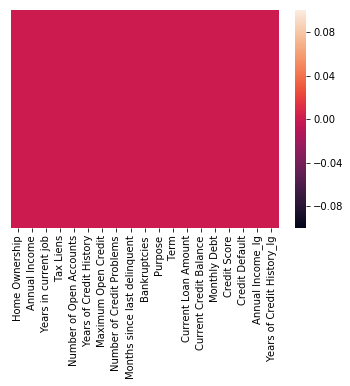

In [37]:
sns.heatmap(df_train.isnull(),yticklabels=False)

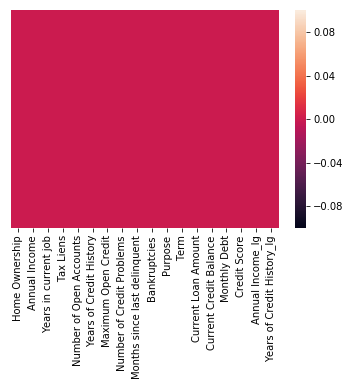

In [38]:
sns.heatmap(df_test.isnull(),yticklabels=False)

#### Оценка корелляции

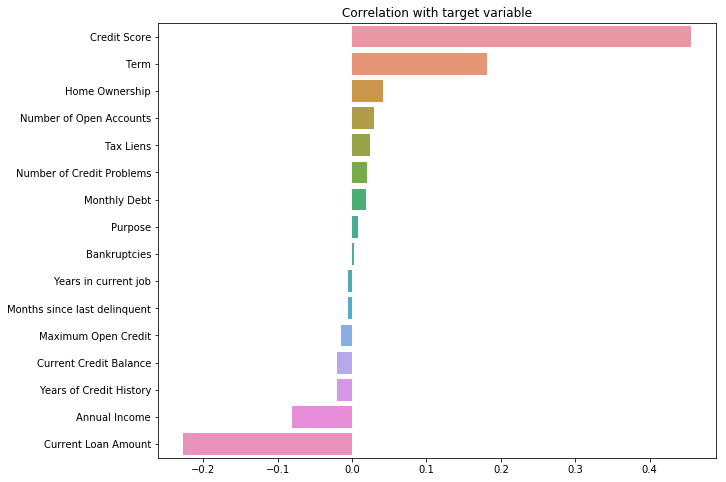

In [39]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

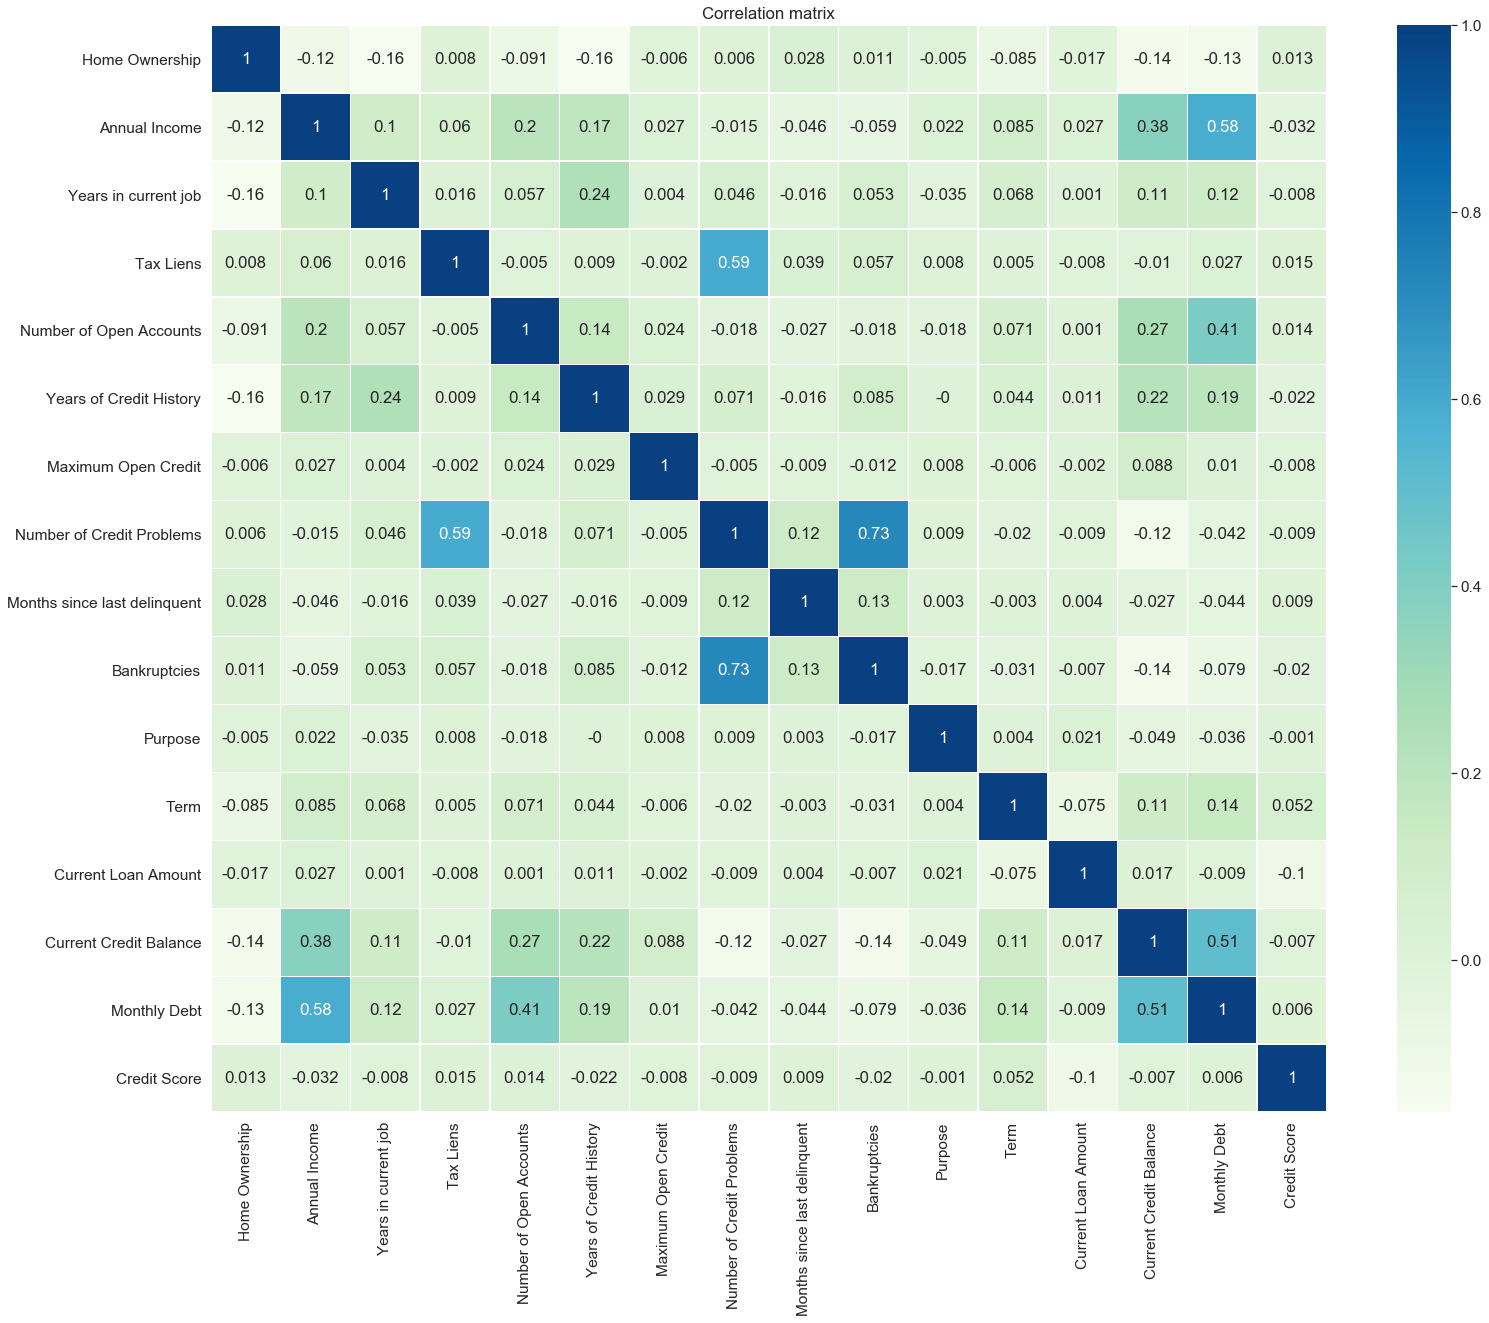

In [41]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

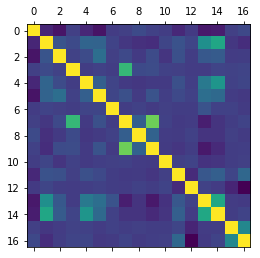

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Home Ownership,1,-0.0963593,-0.158101,0.0079236,-0.0905426,-0.162704,-0.00624079,0.00642847,0.0500761,0.010875,-0.00487911,-0.0850007,-0.0167369,-0.142266,-0.129947,0.00567064,0.0410951
Annual Income,-0.0963593,1,0.0923937,0.0475714,0.166924,0.165618,0.0219864,-0.0266692,-0.0578212,-0.068045,0.0305851,0.0835513,0.0291535,0.385952,0.500854,-0.0258322,-0.0639635
Years in current job,-0.158101,0.0923937,1,0.0157614,0.0521293,0.215283,0.00352282,0.042803,-0.0162242,0.0527376,-0.0357216,0.0725437,-0.00300435,0.109044,0.124562,-0.00743452,-0.00511138
Tax Liens,0.0079236,0.0475714,0.0157614,1,-0.00536002,0.00910933,-0.00240974,0.595339,0.0472001,0.0573248,0.0083615,0.00495296,-0.00783517,-0.0101952,0.0272111,0.0145041,0.0243683
Number of Open Accounts,-0.0905426,0.166924,0.0521293,-0.00536002,1,0.144819,0.0238965,-0.0178126,-0.0256851,-0.0198983,-0.0176896,0.071316,0.00134566,0.267325,0.413904,0.0110807,0.0288838
Years of Credit History,-0.162704,0.165618,0.215283,0.00910933,0.144819,1,0.0292473,0.071259,-0.0145701,0.0854183,-0.0002357,0.0442427,0.010623,0.217856,0.191978,-0.00882646,-0.0205671
Maximum Open Credit,-0.00624079,0.0219864,0.00352282,-0.00240974,0.0238965,0.0292473,1,-0.00474968,0.0101601,-0.0116598,0.0081158,-0.00602251,-0.00233446,0.0880901,0.0101969,0.012608,-0.0142748
Number of Credit Problems,0.00642847,-0.0266692,0.042803,0.595339,-0.0178126,0.071259,-0.00474968,1,0.141421,0.729346,0.00873323,-0.0204331,-0.00859643,-0.124137,-0.0422519,-0.00164304,0.0200883
Months since last delinquent,0.0500761,-0.0578212,-0.0162242,0.0472001,-0.0256851,-0.0145701,0.0101601,0.141421,1,0.158377,-0.00894567,-0.0152129,0.00877696,-0.0404781,-0.0431417,0.00374136,-0.0118148
Bankruptcies,0.010875,-0.068045,0.0527376,0.0573248,-0.0198983,0.0854183,-0.0116598,0.729346,0.158377,1,-0.015293,-0.0308016,-0.00455885,-0.142776,-0.0789005,-0.00612787,0.0024777


In [35]:
X_corr = df_train.corr()
plt.matshow(X_corr)
plt.show()
X_corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Потренироваться проверить гипотезы - Нулевая гипотеза: признаки 1 и 2 согласованы

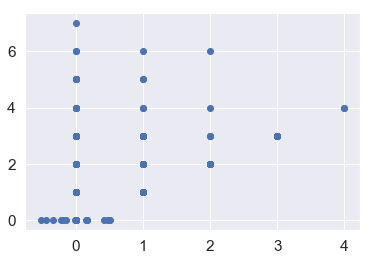

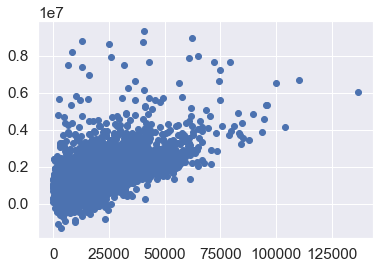

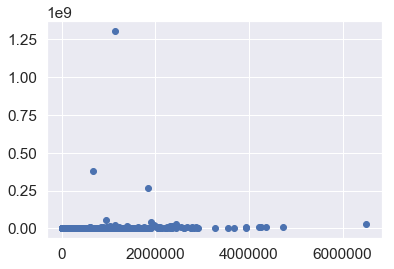

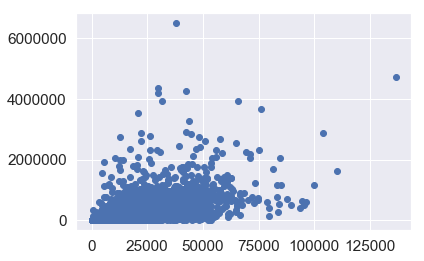

In [42]:
# Зависимость кореллирующих признаков
plt.scatter(df_train['Bankruptcies'], df_train['Number of Credit Problems'])
plt.show()

plt.scatter(df_train['Monthly Debt'], df_train['Annual Income'])
plt.show()

plt.scatter(df_train['Current Credit Balance'], df_train['Maximum Open Credit'])
plt.show()

plt.scatter(df_train['Monthly Debt'], df_train['Current Credit Balance'])
plt.show()

### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

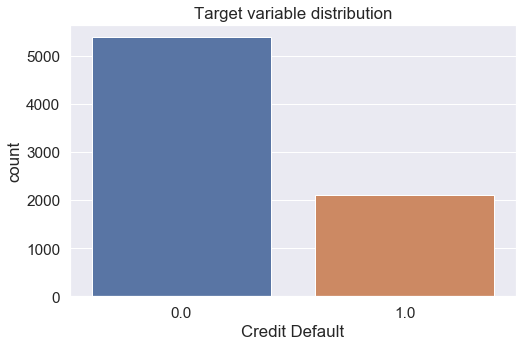

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64

In [48]:
# Обзор распределения целевой переменной
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()
df_train[TARGET_NAME].value_counts()

In [49]:
5387/2113

2.549455750118315

In [50]:
# Обзор признаков
print('BASE_FEATURE_NAMES:',BASE_FEATURE_NAMES)
print('\nCAT_FEATURE_NAMES:', CAT_FEATURE_NAMES)
# NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))
print('\nNUM_FEATURE_NAMES:',NUM_FEATURE_NAMES)



BASE_FEATURE_NAMES: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

CAT_FEATURE_NAMES: ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']

NUM_FEATURE_NAMES: ['Number of Open Accounts', 'Maximum Open Credit', 'Credit Score', 'Years of Credit History_lg', 'Monthly Debt', 'Current Credit Balance', 'Annual Income_lg', 'Months since last delinquent', 'Current Loan Amount']


In [52]:
# Отбор признаков 1
SELECTED_FEATURE_NAMES = CAT_FEATURE_NAMES + NUM_FEATURE_NAMES
SELECTED_FEATURE_NAMES
# Проверить влияние на результат

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Credit Score',
 'Years of Credit History_lg',
 'Monthly Debt',
 'Current Credit Balance',
 'Annual Income_lg',
 'Months since last delinquent',
 'Current Loan Amount']

In [51]:
# Отбор признаков - все
# SELECTED_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 
#                           'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
#                           'Maximum Open Credit', 'Number of Credit Problems',
#                           'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 
#                           'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#                           'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

In [100]:
# Отбор признаков - влияющие
# SELECTED_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 
#                           'Tax Liens', 'Number of Open Accounts',
#                           'Maximum Open Credit', 'Months since last delinquent', 
#                           'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 
#                           'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg',
#                           'Number of Open Accounts_lg', 'Monthly Debt_lg']


In [53]:
# Нормализация данных

scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [54]:
# Разбиение на train и test
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [57]:
# Сохранение модели для нормализации данных
SCALER_FILE_PATH = '../scaler.pkl'

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [55]:
# Балансировка целевой переменной
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
a = df_balanced[TARGET_NAME].value_counts()
print(a, a[0]/a[1])

0.0    3771
1.0    2958
Name: Credit Default, dtype: int64 1.2748478701825559


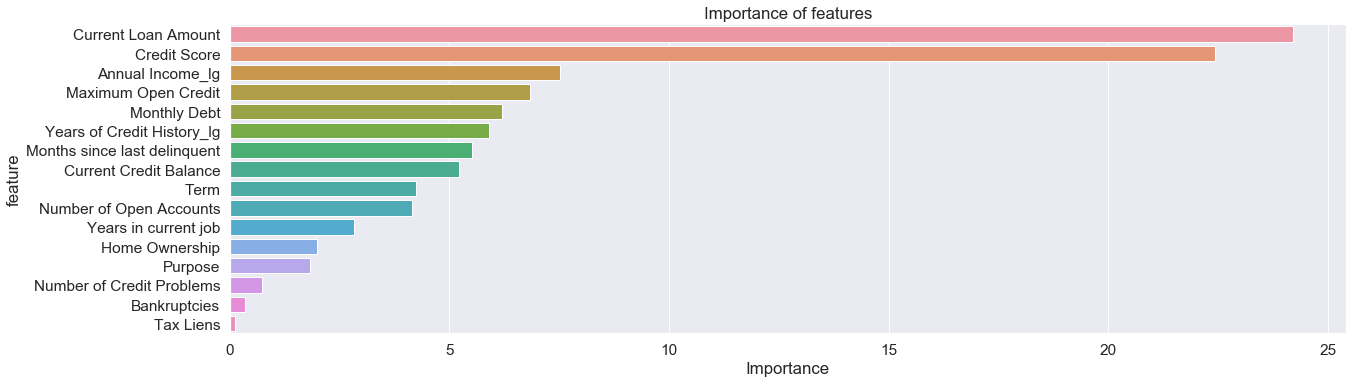

In [58]:

model = catb.CatBoostClassifier(silent=True)
model.fit(X, y)

important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=15)

In [59]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Annual Income_lg',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History_lg',
 'Months since last delinquent',
 'Current Credit Balance',
 'Term',
 'Number of Open Accounts',
 'Years in current job',
 'Home Ownership',
 'Purpose',
 'Number of Credit Problems',
 'Bankruptcies']

In [60]:
SELECTED_FEATURE_NAMES = ['Current Loan Amount',
 'Credit Score',
 'Annual Income_lg',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History_lg',
 'Months since last delinquent',
 'Current Credit Balance',
 'Term',
 'Number of Open Accounts',
 'Years in current job',
 'Home Ownership',
 'Purpose']

In [61]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [145]:
# чекпоинт -  Сохранение обучающего и тестового датасетов

# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

# df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
# train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
# test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

In [62]:
# обратное приведение типов для модели 
for colname in SELECTED_FEATURE_NAMES:
    df_train[colname] = pd.to_numeric(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               float64
Years in current job         float64
Tax Liens                    float64
Number of Credit Problems    float64
Bankruptcies                 float64
Purpose                      float64
Term                         float64
dtype: object

In [63]:
# Логистическая регрессия
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70      3771
         1.0       0.62      0.58      0.60      2958

    accuracy                           0.66      6729
   macro avg       0.65      0.65      0.65      6729
weighted avg       0.66      0.66      0.66      6729

TEST

              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77      1616
         1.0       0.46      0.60      0.52       634

    accuracy                           0.69      2250
   macro avg       0.64      0.66      0.64      2250
weighted avg       0.72      0.69      0.70      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1162  454
1.0              252  382


In [64]:
# Приведение типов для модели CatBoost
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Years in current job         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
Purpose                      category
Term                         category
dtype: object

In [65]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      3771
         1.0       0.95      0.87      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      1616
         1.0       0.63      0.51      0.56       634

    accuracy                           0.78      2250
   macro avg       0.72      0.69      0.71      2250
weighted avg       0.77      0.78      0.77      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1427  189
1.0              313  321


#### Выбор лучшей модели и подбор гиперпараметров

In [66]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 1.27], silent=True, random_state=21)

In [67]:
# Подбор гиперпараметров
params = {'n_estimators':[200, 500, 700, 1000, 1200, 1500, 2000, 2500, 3000, 4000, 5000],
          'max_depth':[3, 4, 5, 7]}

In [68]:
cv=KFold(n_splits=4, random_state=21, shuffle=True)

In [69]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 25.4 s, sys: 977 ms, total: 26.4 s
Wall time: 2min 14s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x1a1c95ac10>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 7],
                                        'n_estimators': [200, 500, 700, 1000,
                                                         1200, 1500, 2000, 2500,
                                                         3000, 4000, 5000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [70]:
rs.best_params_

{'n_estimators': 4000, 'max_depth': 4}

In [71]:
rs.best_score_

0.5326919837095349

### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [72]:
final_model = catb.CatBoostClassifier(n_estimators=4000, max_depth=4,
                                      l2_leaf_reg=10, class_weights=[1, 1.27],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3771
         1.0       0.96      0.98      0.97      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      1616
         1.0       0.56      0.56      0.56       634

    accuracy                           0.75      2250
   macro avg       0.70      0.69      0.69      2250
weighted avg       0.75      0.75      0.75      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1344  272
1.0              282  352


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>


In [77]:
final_model = catb.CatBoostClassifier(n_estimators=4000, max_depth=4,
                                      l2_leaf_reg=10, class_weights=[1, 1.27],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3771
         1.0       0.96      0.98      0.97      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      1616
         1.0       0.56      0.56      0.56       634

    accuracy                           0.75      2250
   macro avg       0.70      0.69      0.69      2250
weighted avg       0.75      0.75      0.75      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1344  272
1.0              282  352


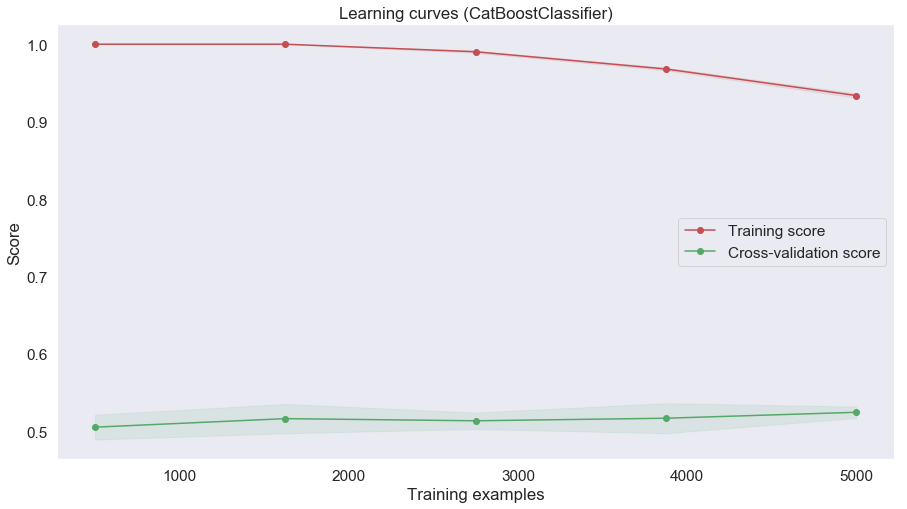

In [78]:
show_learning_curve_plot(final_model, X, y)

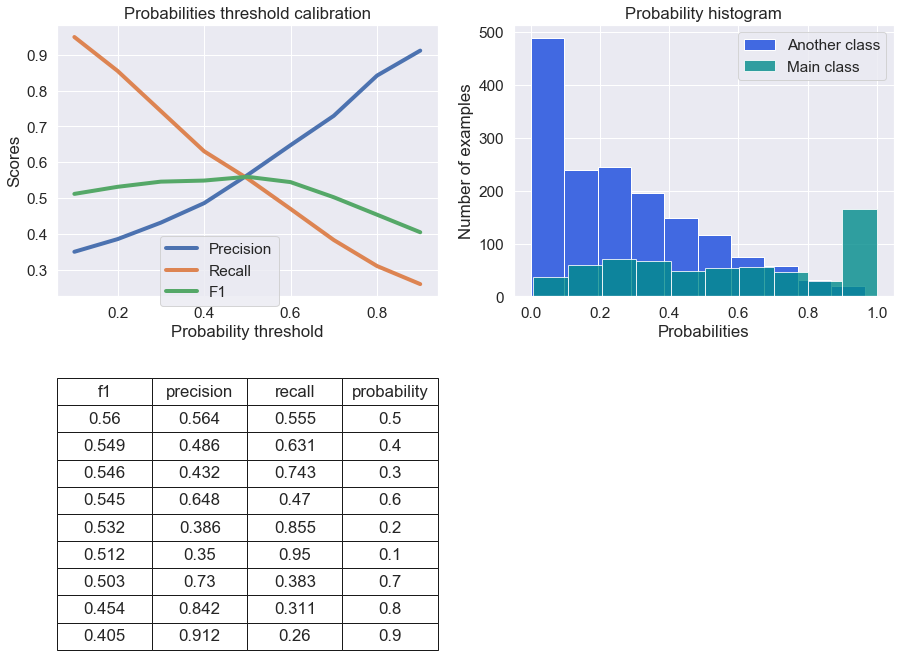

In [79]:
y_test_pred_probs = final_model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Финальная модель<a class="anchor" id="final_model"></a>


In [88]:
final_model = catb.CatBoostClassifier(n_estimators=4000, max_depth=4,
                                      l2_leaf_reg=40, class_weights=[1, 1.27],
                                      silent=True, random_state=21)

final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      3771
         1.0       0.92      0.94      0.93      2958

    accuracy                           0.94      6729
   macro avg       0.94      0.94      0.94      6729
weighted avg       0.94      0.94      0.94      6729

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82      1616
         1.0       0.55      0.57      0.56       634

    accuracy                           0.75      2250
   macro avg       0.69      0.69      0.69      2250
weighted avg       0.75      0.75      0.75      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1326  290
1.0              274  360


In [89]:
df_test_final = df_test.copy()
df_test_final[TARGET_NAME]=pd.Series(final_model.predict(df_test))

In [90]:
df_test_final.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual Income_lg,Years of Credit History_lg,Credit Default
0,2.0,8.589945e+05,4.0,0.0,9.0,12.5,220968.0,0.0,70.000000,0.0,1.0,0.0,162470.0,105906.0,6813.0,4629.210988,14.509636,2.525729,1.0
1,2.0,2.318380e+05,1.0,0.0,6.0,32.7,55946.0,0.0,8.000000,0.0,12.0,0.0,78298.0,46037.0,2318.0,699.000000,12.353794,3.487375,1.0
2,1.0,1.152540e+06,3.0,0.0,10.0,13.7,204600.0,0.0,25.444070,0.0,1.0,0.0,200178.0,146490.0,18729.0,7260.000000,13.957479,2.617396,1.0
3,1.0,1.220313e+06,10.0,0.0,16.0,17.0,456302.0,0.0,70.000000,0.0,1.0,0.0,217382.0,213199.0,27559.0,739.000000,14.014618,2.833213,0.0
4,1.0,2.340952e+06,6.0,0.0,11.0,23.6,1207272.0,0.0,49.156149,0.0,1.0,1.0,777634.0,425391.0,42605.0,706.000000,14.666068,3.161247,0.0


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [91]:
# output
MODEL_FILE_PATH = '../DyachenkoDA_df_test_56'
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

df_test_final.to_csv('DyachenkoDA_df_test_answer_56.csv', index=False, encoding='utf-8')